# **Finding cars** 
***
The goal of this notebook is to identify and mark cars on the road with bounding boxes.  It is separated into 6 parts:
1. Define methods for extracting Histogram of Oriented Gradients (HOG) features and visualize results
2. Train and test a Support Vector Machine Classifier that uses HOG features to distinguish car and non-car images
3. Define methods for sliding windows across full images and searching each window for potential cars
4. Use window methods on test images and visualize bounding boxes to gauge quality of the SVM classifier
5. Define methods to use a heatmap technique to turn overlapping 'car windows' into a single bounding box per car
6. Add end-to-end process to a single method, and add ability for it to share data between video frames. Run it on the test video
---

# **Part 1: Define methods for extracting Histogram of Oriented Gradients (HOG) features and visualize results** 
***
The method extract_features combines the others and can provide all the features for a set of images.  The method single_img_features does the same on a single image.

---

In [28]:
# Import libraries and define method for plotting

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

def multiplot(fig,rows,cols,imgs,titles,save_to_disk_with_filename=False):
    for i,img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        if len(img.shape) < 3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
    if save_to_disk_with_filename:
        plt.savefig(save_to_disk_with_filename)

In [29]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                    hist_bins=32, orient = 9,pix_per_cell=8,cell_per_block=2,hog_channel=0,
                    spatial_feat=True,hist_feat=True,hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
#         print(file)
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)                
        else: feature_image = np.copy(image)
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)            
        
            
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features ))
    # Return list of feature vectors
    return features

# Define a method to extract features from a single image window, similar to extract_features()
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True)) 
#             hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features,hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)                
                
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

In [30]:
# Load image paths
vehicles = glob.glob('vehicles/*/*.png')
nonvehicles = glob.glob('non-vehicles/*/*.png')
print(len(vehicles),"vehicle images found")
print(len(nonvehicles),"nonvehicle images found")

8792 vehicle images found
8968 nonvehicle images found


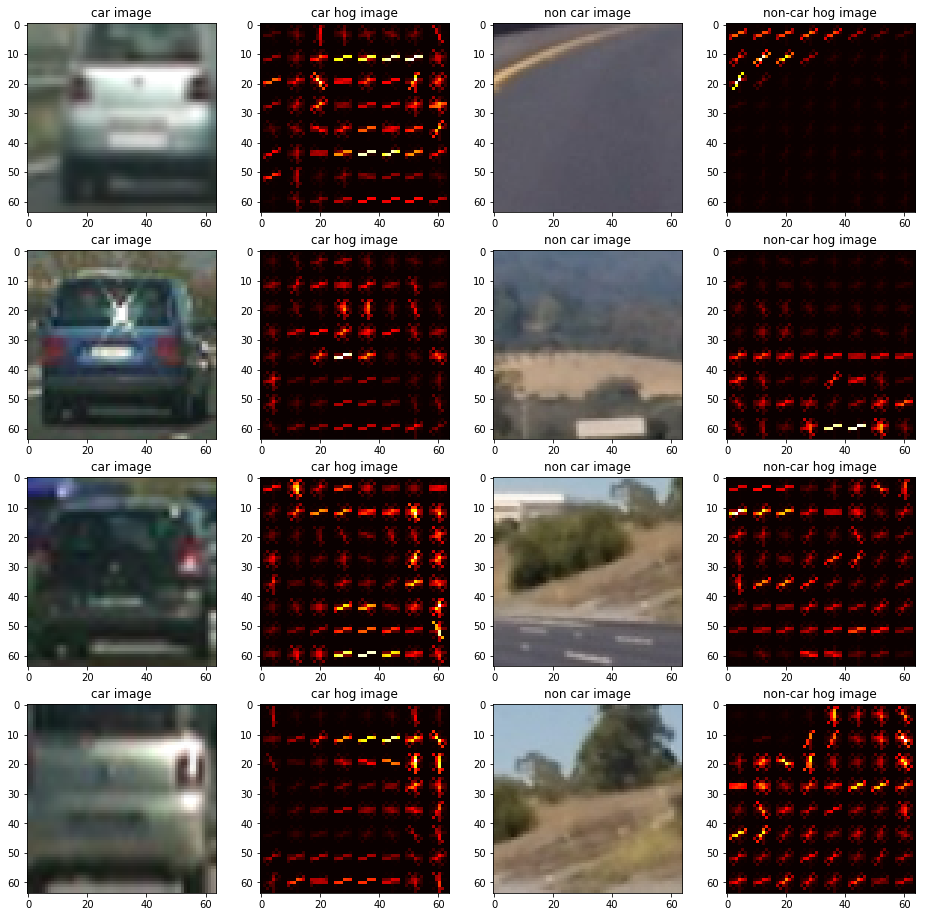

In [31]:
# Define constants used for HOG
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

# Prep lists for multiplot
titles = []
images =[]

#Sample a few images
for i in range(100,500,100):
    car_image = mpimg.imread(vehicles[i])
    features,car_hog_image = single_img_features(car_image, color_space=color_space,spatial_size=spatial_size,
                                          hist_bins=hist_bins,orient=orient, pix_per_cell=pix_per_cell,
                                          cell_per_block=cell_per_block,hog_channel=0,
                                          spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat,vis=True)
    images.append(car_image)
    titles.append('car image')
    images.append(car_hog_image)
    titles.append('car hog image')
    
    non_car_image = mpimg.imread(nonvehicles[i])
    features,non_car_hog_image = single_img_features(non_car_image, color_space=color_space,spatial_size=spatial_size,
                                          hist_bins=hist_bins,orient=orient, pix_per_cell=pix_per_cell,
                                          cell_per_block=cell_per_block,hog_channel=0,
                                          spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat,vis=True)
    images.append(non_car_image)
    titles.append('non car image')
    images.append(non_car_hog_image)
    titles.append('non-car hog image')    
    
    
fig = plt.figure(figsize=(16,16))
multiplot(fig,4,4,images,titles,'output_images/car_and_noncar_hogs.png')


# **Part 2: Train and test a Support Vector Machine Classifier that uses HOG features to distinguish car and non-car images** 
***
I pull out the features of cars and non-cars separately, so I can easily pair them with their targets.  I stack them and scale X to zero mean and unit variance.  Finally, I train and test the model.

---

In [32]:
print('Extracting car features...')
car_features = extract_features(np.array(vehicles), cspace=color_space,spatial_size=spatial_size,
                                          hist_bins=hist_bins,orient=orient, pix_per_cell=pix_per_cell,
                                          cell_per_block=cell_per_block,hog_channel=hog_channel,
                                          spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)
print('Extracting noncar features...')
notcar_features = extract_features(np.array(nonvehicles), cspace=color_space,spatial_size=spatial_size,
                                          hist_bins=hist_bins,orient=orient, pix_per_cell=pix_per_cell,
                                          cell_per_block=cell_per_block,hog_channel=hog_channel,
                                          spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)

# Stack and scale Xs
X = np.vstack((car_features,notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Create and stack Ys
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split into train and test set
X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,test_size=0.1)

# Build a classifier and train
svc = LinearSVC()
print('Fitting...')
svc.fit(X_train,y_train)


print('Test set accuracy score: ',svc.score(X_test,y_test))


Extracting car features...
Extracting noncar features...
Fitting...
Test set accuracy score:  0.993243243243


# **Part 3: Define methods for sliding windows across full images and searching each window for potential cars **
***
These methods take a classifier as an argument and allow for the image to be 'window-scanned' for car/non-car results results.

---

In [33]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

# **Part 4: Use window methods on test images and visualize bounding boxes to gauge quality of the SVM classifier** 
***
This test is more telling than the accuracy score because it's close to what we do in the final video.

---

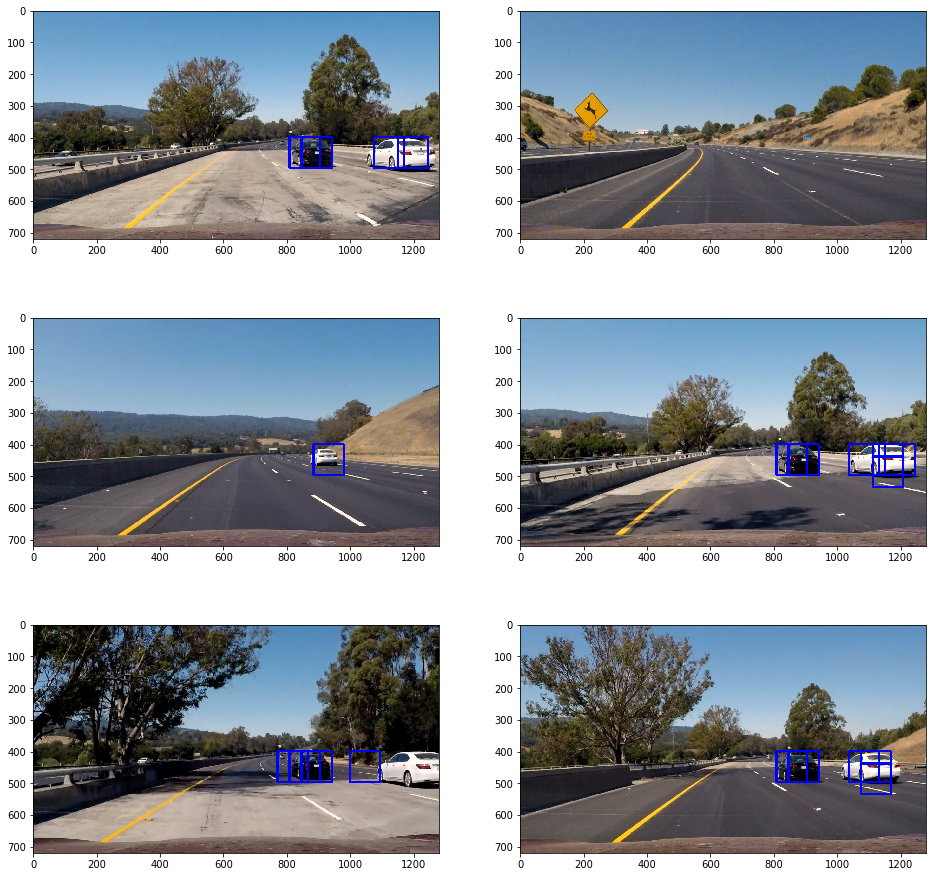

In [38]:
# Test out SVC model by searching windows
test_images = glob.glob('./test_images/*')

# Prep lists for multiplot
images = []
titles = []

# Pick region to search and amount of overlap
y_start_stop = [400,650]
x_start_stop = [580,1280]
overlap = 0.6

for img_path in test_images:
    img = mpimg.imread(img_path)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    windows = slide_window(img,x_start_stop=x_start_stop,y_start_stop=y_start_stop,
                          xy_window=(96,96),xy_overlap=(overlap,overlap))
    hot_windows = search_windows(img,windows,svc,X_scaler,color_space=color_space,spatial_size=spatial_size,
                                hist_bins=hist_bins,orient=orient,pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)

    window_img = draw_boxes(draw_img,hot_windows,color=(0,0,255),thick=6)
    images.append(window_img)
    titles.append('')
    
fig = plt.figure(figsize=(16,16))
multiplot(fig,3,2,images,titles,'output_images/simple_window_examples.png')

# **Part 5: Define methods to use a heatmap technique to turn overlapping 'car windows' into a single bounding box per car, and visualize end-to-end process with test images**
***
The heatmap labeling method takes a heat threshold which can be tuned.  If the density of windows is higher, a higher threshold is likely needed.

---

In [35]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



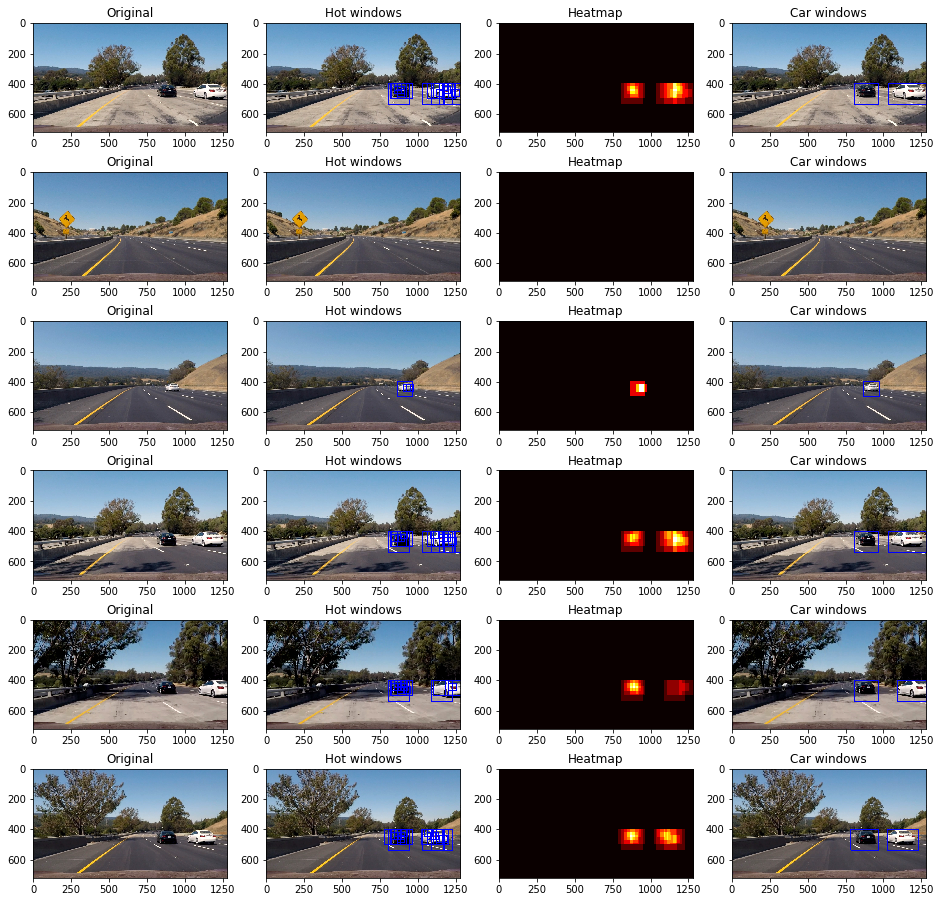

In [40]:

# Prep lists for multiplot
images = []
titles = []

# Pick region to search and amount of overlap
y_start_stop = [400,650]
x_start_stop = [580,1280]
overlap = 0.6

for img_path in test_images:
    img = mpimg.imread(img_path)
    
    # Create blank image and copy for later use
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    draw_img = np.copy(img)
    
    img = img.astype(np.float32)/255
    
    # Small windows
    small_windows = slide_window(img,x_start_stop=x_start_stop,y_start_stop=y_start_stop,
                          xy_window=(50,50),xy_overlap=(overlap,overlap))
    small_hot_windows = search_windows(img,small_windows,svc,X_scaler,color_space=color_space,spatial_size=spatial_size,
                                hist_bins=hist_bins,orient=orient,pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)
    
    # Large windows
    large_windows = slide_window(img,x_start_stop=x_start_stop,y_start_stop=y_start_stop,
                          xy_window=(100,100),xy_overlap=(overlap,overlap))
    large_hot_windows = search_windows(img,large_windows,svc,X_scaler,color_space=color_space,spatial_size=spatial_size,
                                hist_bins=hist_bins,orient=orient,pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)
    
    # Extra large windows
    xlarge_windows = slide_window(img,x_start_stop=x_start_stop,y_start_stop=y_start_stop,
                          xy_window=(140,140),xy_overlap=(overlap,overlap))
    xlarge_hot_windows = search_windows(img,xlarge_windows,svc,X_scaler,color_space=color_space,spatial_size=spatial_size,
                                hist_bins=hist_bins,orient=orient,pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)    
        
    # Collect 'hot' windows that found cars
    hot_windows = small_hot_windows + large_hot_windows + xlarge_hot_windows
    hot_window_img = draw_boxes(draw_img,hot_windows,color=(0,0,255),thick=6)

    # Create heatmap with hot_windows
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,0)
    heatmap_img = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label method
    labels = label(heatmap_img)
    car_windows_img = draw_labeled_bboxes(draw_img, labels)

    images.append(img)
    images.append(hot_window_img)
    images.append(heatmap_img)
    images.append(car_windows_img)    
    titles.append('Original')
    titles.append('Hot windows')
    titles.append('Heatmap')
    titles.append('Car windows')    
    

fig = plt.figure(figsize=(16,16))
multiplot(fig,6,4,images,titles,'output_images/car_window_process.png')

# **Part 6: Add end-to-end process to a single method, and add ability for it to share data between video frames. Run it on the test video**
***
The heat threshold here is higher (3) than it was for single images because now each 'process' adds 'heat' from 8 full frames.  These were both important hyperparamters that needed to be tuned.

---

In [85]:
# Define a global list to use in between-frame data-sharing
RECENT_HOT_WINDOW_SETS = []

def process_image(img):
    global RECENT_HOT_WINDOW_SETS
    
    # How many frames back to consider
    prev_frames_considered = 8
    
    # Threshold greater than for single images because now we have heat from 8 frames instead of 1
    heat_threshold = 3
    
    # Create blank image and copy for later use
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    draw_img = np.copy(img)
    
    img = img.astype(np.float32)/255
    
    # Small windows    
    small_windows = slide_window(img,x_start_stop=x_start_stop,y_start_stop=y_start_stop,
                          xy_window=(50,50),xy_overlap=(overlap,overlap))
    small_hot_windows = search_windows(img,small_windows,svc,X_scaler,color_space=color_space,spatial_size=spatial_size,
                                hist_bins=hist_bins,orient=orient,pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)
    # Large windows
    large_windows = slide_window(img,x_start_stop=x_start_stop,y_start_stop=y_start_stop,
                          xy_window=(100,100),xy_overlap=(overlap,overlap))
    large_hot_windows = search_windows(img,large_windows,svc,X_scaler,color_space=color_space,spatial_size=spatial_size,
                                hist_bins=hist_bins,orient=orient,pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)
    # Extra large windows
    xlarge_windows = slide_window(img,x_start_stop=x_start_stop,y_start_stop=y_start_stop,
                          xy_window=(140,140),xy_overlap=(overlap,overlap))
    xlarge_hot_windows = search_windows(img,xlarge_windows,svc,X_scaler,color_space=color_space,spatial_size=spatial_size,
                                hist_bins=hist_bins,orient=orient,pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)    
        
    # Collect 'hot' windows that found cars
    hot_windows = small_hot_windows + large_hot_windows + xlarge_hot_windows
    
    # Slice list to maintain length and add newest hot windows
    RECENT_HOT_WINDOW_SETS = RECENT_HOT_WINDOW_SETS[-prev_frames_considered:]
    RECENT_HOT_WINDOW_SETS.append(hot_windows)
    
    # Flatten global list of hot windows and add to heatmap
    heat = add_heat(heat,[item for sublist in RECENT_HOT_WINDOW_SETS for item in sublist])
    heat = apply_threshold(heat,heat_threshold)
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label method
    labels = label(heatmap)
    car_windows_image = draw_labeled_bboxes(draw_img, labels)
       
    return car_windows_image

In [88]:
# Apply the pipleline to the example video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

RECENT_HOT_WINDOW_SETS = []
output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video output2.mp4
[MoviePy] Writing video output2.mp4


100%|█████████▉| 1260/1261 [49:02<00:02,  2.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output2.mp4 

CPU times: user 42min 53s, sys: 56.2 s, total: 43min 49s
Wall time: 49min 4s


In [89]:

HTML("""
<video width="960" height="540" controls> 
  <source src="{0}">
</video>
""".format(output))